# 1. Setup

## 1.1 Imports

In [1]:
import numpy as np

from tensorflow.keras.applications.vgg16 import VGG16

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, Input, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

import bees_utils_macro as utils
import datetime


## 1.2 Set random seeds

In [2]:
np.random.seed(117)
tf.random.set_seed(117)

## 1.3 Global variables

In [3]:
img_width = 100
img_height = 100
img_channels = 3

# 2. Carga de datos

In [4]:
bees, bees_test_for_evaluation = utils.read_data()

In [5]:
bees.head()

,id,datetime,file,location,zip code,subspecies,health,pollen_carrying,caste
0,0,2018-08-06 14:48:00,020_011.png,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker
1,1,2018-08-21 09:00:00,032_507.png,"Des Moines, IA, USA",50315,Russian honey bee,healthy,False,worker
2,2,2018-08-21 09:00:00,032_612.png,"Des Moines, IA, USA",50315,Russian honey bee,healthy,False,worker
3,3,2018-08-17 17:50:00,030_773.png,"Alvin, TX, USA",77511,Italian honey bee,ant problems,False,worker
4,4,2018-08-06 13:19:00,015_1052.png,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker


In [6]:
bees_test_for_evaluation.head()

,id,datetime,file,location,zip code,pollen_carrying,caste
0,0,2018-08-28 16:07:00,042_012.png,"Alvin, TX, USA",77511,False,worker
1,1,2018-08-10 13:54:00,022_114.png,"Saratoga, CA, USA",95070,False,worker
2,2,2018-08-18 12:30:00,038_384.png,"Athens, Georgia, USA",30607,False,worker
3,3,2018-08-17 17:50:00,030_740.png,"Alvin, TX, USA",77511,False,worker
4,4,2018-07-07 12:56:00,005_310.png,"Saratoga, CA, USA",95070,False,worker


# 3. Análisis exploratorio de datos

## 3.1 Análisis descriptivo: Distribuciones, Scatterplots, Barplots...

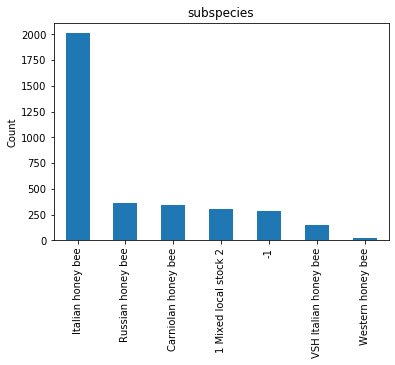

In [7]:
utils.value_counts(bees, 'subspecies')

## 3.2 Ver imágenes

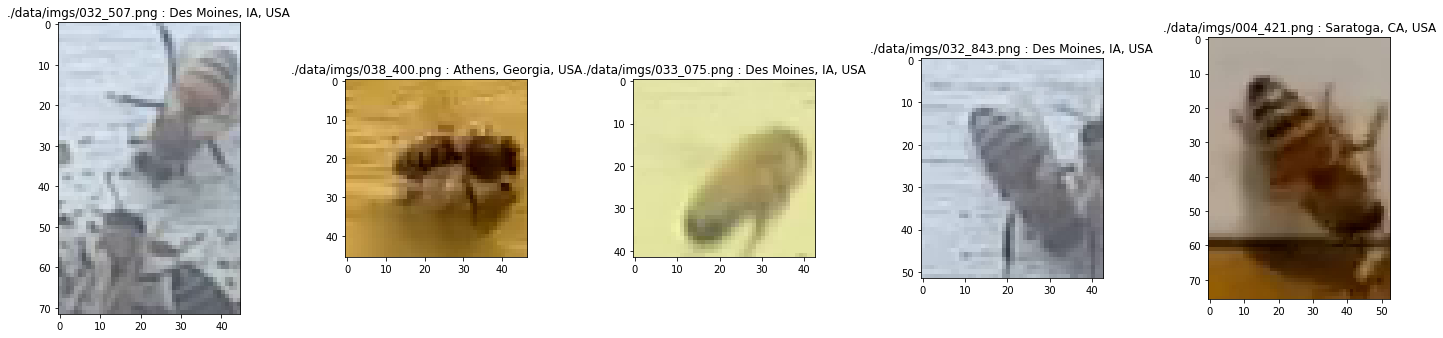

In [8]:
utils.plot_images(bees, 'location', [1, 25, 7, 100, 254])

# 4. Clasificación

## 4.1. Data preprocessing
### 4.1.1 Particionamiento

In [9]:
train_bees, val_bees, test_bees = utils.split(bees)


### 4.1.2 Carga de imágenes

In [10]:
# esta función ya uniformiza todas las imágenes en 100x100
train_X, val_X, test_X, train_y, val_y, test_y = utils.load_images_and_target(train_bees, 
                                                                              val_bees, 
                                                                              test_bees,
                                                                              'subspecies',
                                                                              img_width, 
                                                                              img_height,
                                                                              img_channels)

In [11]:
train_bees['subspecies']

225       Italian honey bee
2453      Italian honey bee
3009      Italian honey bee
3270    Carniolan honey bee
2622      Italian honey bee
               ...         
1275                     -1
1439      Italian honey bee
1175      Italian honey bee
2765      Italian honey bee
189     Carniolan honey bee
Name: subspecies, Length: 2338, dtype: category
Categories (7, object): [-1, 1 Mixed local stock 2, Carniolan honey bee, Italian honey bee, Russian honey bee, VSH Italian honey bee, Western honey bee]

In [12]:
utils.categories['subspecies']

array(['-1', '1 Mixed local stock 2', 'Carniolan honey bee',
       'Italian honey bee', 'Russian honey bee', 'VSH Italian honey bee',
       'Western honey bee'], dtype=object)

In [13]:
utils.class_indices['subspecies']

array([0, 1, 2, 3, 4, 5, 6])

In [14]:
class_weights = utils.class_weights(bees, 'subspecies')
class_weights = dict(enumerate(class_weights))
class_weights

{0: 1.7553191489361701,
 1: 1.6445182724252492,
 2: 1.438953488372093,
 3: 0.2462686567164179,
 4: 1.375,
 5: 3.3904109589041096,
 6: 22.5}

## 4.2 CNN

In [15]:
optimizer = Adam(lr = 0.001)
loss = 'categorical_crossentropy'

In [16]:
train_y.columns.size

7

In [17]:
#base_model = VGG16(weights='imagenet', include_top=False)

#for layer in base_model.layers:
#layer.trainable = False


base_model = VGG16(include_top=False, weights='imagenet', input_shape=(img_width, img_height, img_channels))

# congelo las capas del VGG16
base_model.trainable = False

#for layer in base_model.layers[:]:
 #   layer.trainable = False

model_input = Input((img_height, img_width, img_channels))

x = base_model (model_input, training=False)

#x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.1)(x)  # Regularize with dropout

y1 = Flatten()(x)
y1 = Dense(train_y.columns.size, activation = 'softmax')(y1)

model1 = Model(inputs=model_input, outputs=y1)


In [18]:
model1.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 32263     
Total params: 14,746,951
Trainable params: 32,263
Non-trainable params: 14,714,688
_________________________________________________________________


In [19]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [20]:
model1.compile(optimizer = optimizer, 
               loss = loss, 
               metrics = [utils.MacroAverageRecallMetric(num_classes = train_y.columns.size)])

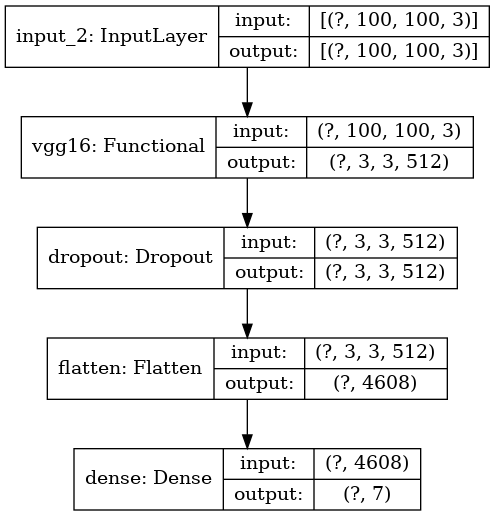

In [21]:
current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
modelname = './models/' + model1.name + '_' + current_time
keras.utils.plot_model(model1, to_file = modelname + '.png', show_shapes = True)

## 4.3 Entrenamiento

### 4.2.2 Parámetros de transformación de imágenes (data augmentation)

In [22]:
rotation_range = 180     # rotación aleatoria en grados entre 0 a rotation_range
zoom_range = 0.1         # zoom aleatorio
width_shift_range = 0.1  # desplazamiento horizontal aleatorio (fracción del total)
height_shift_range = 0.1 # desplazamiento vertical aleatorio (fracción del total)
horizontal_flip = True   # transposición horizontal
vertical_flip = True     # transposición horizontal

In [23]:
batch_size = 30
epochs = 50
#defino un nuevo valor de steps_per_epoch así trabajo solo con batch_size
steps_per_epoch = train_X.shape[0] // batch_size
#steps_per_epoch = 30
patience = 10

In [24]:
earlystopper = EarlyStopping(monitor='val_loss', 
                             patience=patience, verbose=1,restore_best_weights=True)
callbacks = [earlystopper]

In [25]:
steps_per_epoch

77

In [26]:
train_X.shape

(2338, 100, 100, 3)

In [27]:
filepath = './checkpoints/' + model1.name + '_' + current_time + '_{epoch:02d}_{val_loss:.2f}.h5'
checkpoint = ModelCheckpoint(filepath, 
                             monitor="val_loss", verbose=1, save_best_only=True)
callbacks.append(checkpoint)

In [28]:
bestepoch = utils.BestEpochCallback()
callbacks.append(bestepoch)

In [29]:
training1, model1 = utils.train(model1,
                                train_X, 
                                train_y, 
                                batch_size = batch_size,
                                epochs = epochs,
                                validation_data_X = val_X, 
                                validation_data_y = val_y,
                                steps_per_epoch = steps_per_epoch,
                                rotation_range = rotation_range,
                                zoom_range = zoom_range, 
                                width_shift_range = width_shift_range,
                                height_shift_range = height_shift_range,
                                horizontal_flip = horizontal_flip,  
                                vertical_flip = vertical_flip,
                                callbacks = callbacks,
                                class_weights = class_weights
                               )

Epoch 1/50
77/77 [==============================] - ETA: 0s - loss: 1.5364 - macro: 0.4650
Epoch 00001: val_loss improved from inf to 1.23701, saving model to ./checkpoints/functional_1_20201125_171626_01_1.24.h5
77/77 [==============================] - 17s 223ms/step - loss: 1.5364 - macro: 0.4650 - val_loss: 1.2370 - val_macro: 0.4784
Epoch 2/50
77/77 [==============================] - ETA: 0s - loss: 0.9142 - macro: 0.5780
Epoch 00002: val_loss improved from 1.23701 to 0.98621, saving model to ./checkpoints/functional_1_20201125_171626_02_0.99.h5
77/77 [==============================] - 16s 214ms/step - loss: 0.9142 - macro: 0.5780 - val_loss: 0.9862 - val_macro: 0.5855
Epoch 3/50
77/77 [==============================] - ETA: 0s - loss: 0.8068 - macro: 0.6218
Epoch 00003: val_loss improved from 0.98621 to 0.89376, saving model to ./checkpoints/functional_1_20201125_171626_03_0.89.h5
77/77 [==============================] - 16s 206ms/step - loss: 0.8068 - macro: 0.6218 - val_loss: 0.

Epoch 29/50
77/77 [==============================] - ETA: 0s - loss: 0.3271 - macro: 0.8323
Epoch 00029: val_loss did not improve from 0.56268
77/77 [==============================] - 16s 213ms/step - loss: 0.3271 - macro: 0.8323 - val_loss: 0.7652 - val_macro: 0.8324
Epoch 30/50
77/77 [==============================] - ETA: 0s - loss: 0.3521 - macro: 0.8340
Epoch 00030: val_loss did not improve from 0.56268
77/77 [==============================] - 16s 213ms/step - loss: 0.3521 - macro: 0.8340 - val_loss: 0.7493 - val_macro: 0.8341
Epoch 31/50
77/77 [==============================] - ETA: 0s - loss: 0.3158 - macro: 0.8361
Epoch 00031: val_loss did not improve from 0.56268
77/77 [==============================] - 16s 214ms/step - loss: 0.3158 - macro: 0.8361 - val_loss: 0.6424 - val_macro: 0.8362
Epoch 32/50
77/77 [==============================] - ETA: 0s - loss: 0.3208 - macro: 0.8374
Epoch 00032: val_loss did not improve from 0.56268
77/77 [==============================] - 16s 206ms

## 4.3 Evaluación del modelo

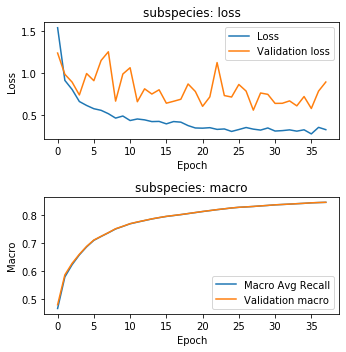

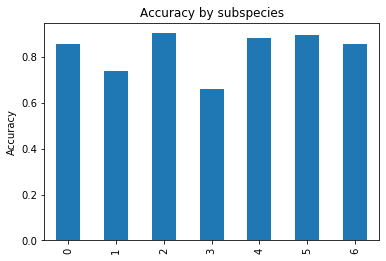

Classification report
                       precision    recall  f1-score   support

                   -1       0.50      0.89      0.64        70
1 Mixed local stock 2       0.68      0.75      0.72        69
  Carniolan honey bee       0.94      0.91      0.93        92
    Italian honey bee       0.91      0.72      0.81       490
    Russian honey bee       0.85      0.90      0.88       110
VSH Italian honey bee       0.47      0.93      0.63        29
    Western honey bee       0.35      1.00      0.52         7

             accuracy                           0.79       867
            macro avg       0.67      0.87      0.73       867
         weighted avg       0.84      0.79      0.80       867

Loss function: 0.515125036239624


In [30]:
utils.eval_model(training1, model1, test_X, test_y, 'subspecies')

In [31]:
trainedmodelname = modelname + '_{:02d}_{:.2f}.h5'.format(bestepoch.best_epoch, bestepoch.best_loss)
model1.save(trainedmodelname)

In [32]:
saved_model = keras.models.load_model(trainedmodelname, 
                                      custom_objects = {'MacroAverageRecallMetric' : utils.MacroAverageRecallMetric})

In [33]:
df_subspecies = utils.load_test_and_generate_prediction_file(model1, img_width, img_height, img_channels, 'subspecies')
df_subspecies

,id,expected
0,0,-1
1,1,Italian honey bee
2,2,1 Mixed local stock 2
3,3,Italian honey bee
4,4,Italian honey bee
...,...,...
1702,1702,-1
1703,1703,1 Mixed local stock 2
1704,1704,-1
1705,1705,Carniolan honey bee
